<a href="https://colab.research.google.com/github/savatarko/Game-of-life-parallel/blob/main/PAProjekat1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inicijalizacija matrice i broja iteracija + nekih stvari koje su potrebne za niti

field = polje na kojima su celije (1-ziva, 0-mrtva)

numofit = broj iteracija

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import threading
import time
import random
import sys
import multiprocessing as mp
import multiprocessing.connection
from queue import Empty
import math

#n = int(input())
n = 25
global field
global counter
global read
global numofit

steps = []

fieldlock = threading.Lock()
readlock = threading.Lock()
waitlock = threading.Lock()

checkbarlock = threading.Lock()
barcount = 0

condition = threading.Condition()


#numofit = int(input())
numofit = 30
newcycle = True

numin = 0
numout = n*n

field = np.random.randint(2, size = (n,n))

readlocks = []

for i in range(0,n*n):
    readlocks.append(threading.Lock())

read = np.zeros((n, n), dtype=int)
counter = 0

barrier = threading.Barrier(parties = n*n)


Funkcija za restartovanje matrice procitanih, i dodaje trenutno stanje u istoriju matrica

In [ ]:
def resetread():
  global read
  global n
  global field
  global steps
  steps.append(list(map(list, field)))
  for i in range(0,n):
    for j in range(0,n):
      read[i][j] = 0

1A

In [ ]:
def cell(i, j):
  global field
  global read
  global numofit

  global readlock
  global fieldlock
  global waitlock

  global newcycle

  global numin
  global numout
  global n
  for x in range(1,numofit):
    cur = 0
    numofreads = 0

    for ii in range(i-1, i+2):
      for jj in range(j-1, j+2):
        if ii == i and jj == j:
          continue
        if ii < 0 or ii > n-1:
          continue
        if jj < 0 or jj > n-1:
          continue
        cur+=field[ii][jj]
        numofreads+=1
        readlocks[ii*n + jj].acquire()
        read[ii][jj]+=1
        readlocks[ii*n + jj].release()

    if cur < 2 or cur > 3:
      new = 0
    else:
      if cur == 3:
        new = 1
      else:
        new = field[i][j]
    while read[i][j]!=numofreads:
      time.sleep(0.05)
    fieldlock.acquire()
    field[i][j] = new
    fieldlock.release()

    while numout != n*n:
      time.sleep(1)
    newcycle = False
    waitlock.acquire()
    numin += 1
    waitlock.release()
    if numin == n*n:
      numin = 0
      numout = 0
      resetread()
      newcycle = True
    while newcycle == False:
      time.sleep(0.05)
    waitlock.acquire()
    numout +=1
    waitlock.release()

1B

In [ ]:
def cellcondition(i, j):
  global field
  global read
  global numofit

  global readlock
  global fieldlock

  global condition

  global newcycle

  global readlocks

  global numin
  global n
  for x in range(1,numofit):
    cur = 0
    numofreads = 0

    for ii in range(i-1, i+2):
      for jj in range(j-1, j+2):
        if ii == i and jj == j:
          continue
        if ii < 0 or ii > n-1:
          continue
        if jj < 0 or jj > n-1:
          continue
        cur+=field[ii][jj]
        numofreads+=1
        readlocks[ii*n + jj].acquire()
        read[ii][jj]+=1
        readlocks[ii*n + jj].release()

    if cur < 2 or cur > 3:
      new = 0
    else:
      if cur == 3:
        new = 1
      else:
        new = field[i][j]
    while read[i][j]!=numofreads:
      time.sleep(0.05)
    fieldlock.acquire()
    field[i][j] = new
    fieldlock.release()

    with condition:
      numin +=1
      if numin < n*n:
        condition.wait()
      else:
        numin = 0
        resetread()
        condition.notifyAll()

1C

In [ ]:
def cellbarrier(i, j):
  global field
  global read
  global numofit

  global readlock
  global fieldlock

  global condition

  global newcycle

  global readlocks

  global checkbarlock
  global barcount

  global barrier

  global numin
  global n
  for x in range(1,numofit):
    cur = 0
    numofreads = 0

    for ii in range(i-1, i+2):
      for jj in range(j-1, j+2):
        if ii == i and jj == j:
          continue
        if ii < 0 or ii > n-1:
          continue
        if jj < 0 or jj > n-1:
          continue
        cur+=field[ii][jj]
        numofreads+=1
        readlocks[ii*n + jj].acquire()
        read[ii][jj]+=1
        readlocks[ii*n + jj].release()

    if cur < 2 or cur > 3:
      new = 0
    else:
      if cur == 3:
        new = 1
      else:
        new = field[i][j]
    while read[i][j]!=numofreads:
      time.sleep(0.05)
    fieldlock.acquire()
    field[i][j] = new
    fieldlock.release()

    read[i][j] = 0

    checkbarlock.acquire()
    barcount += 1
    if barcount == n*n:
      steps.append(list(map(list, field)))
      barcount = 0
    checkbarlock.release()

    barrier.wait()

Animacija

In [ ]:
def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


Pokretanje niti

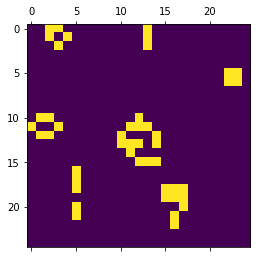

In [ ]:
threads = []
resetread()
for x in range(n * n):
  t = threading.Thread(target = cellbarrier, args=(int(x/n), x%n,))
  t.start()
  threads.append(t)
for t in threads:
  t.join()
#print(steps)
anim = animate(steps)
HTML(anim.to_html5_video())

2

In [ ]:
def cellproc(value, i, j, conns, numofconns, it, queue):
  neighbours = []
  v = value
  #print(conns)
  for x in range(0, numofconns):
    conns[x].send(v)

  for x in range(0, numofconns):
    message = conns[x].recv()
    neighbours.append(int(message))

  for iterator in range(0,it):
    counter = 0
    
    for neighbour in neighbours:
      counter += neighbour

    if counter < 2 or counter > 3:
      v = 0
    if counter == 3:
      v = 1
    queue.put("{} {} {} {}".format(i,j,v, iterator))

    for x in range(0, numofconns):
      conns[x].send(v)

    neighbours = []
    for x in range(0, numofconns):
      message = conns[x].recv()
      neighbours.append(int(message))

Inicijalizacija procesa

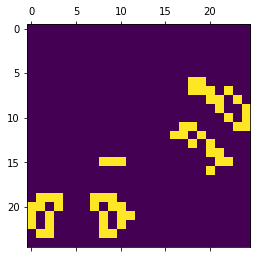

In [ ]:
pipes = [[mp.Pipe() for _ in range(9)] for _ in range(n*n)]

numofcon = [0 for _ in range(n * n)]

queue = mp.Queue(maxsize = n*n + 1)

for i in range(0,n):
  for j in range(0,n):
    for ii in range(i, i+2):
      for jj in range(j-1,j+2):
        if ii == i and jj == j:
          continue
        if ii > n-1:
          continue
        if  jj > n-1 or jj < 0:
          continue
        if ii == i and jj == j-1:
          continue
        pipes[i*n+j][numofcon[i*n+j]], pipes[ii*n + jj][numofcon[ii*n+jj]] = mp.Pipe(duplex = True)
        numofcon[i*n+j] +=1
        numofcon[ii*n+jj]+=1

steps = []
steps.append(list(map(list,field)))
processes = []
for i in range(0,n):
  for j in range(0,n):
    tempcons = []
    for k in range(0, numofcon[i*n+j]):
      tempcons.append(pipes[i*n+j][k])
    p = mp.Process(target = cellproc, kwargs={'value': field[i][j], 'i':i, 'j':j, 'conns': tempcons,'numofconns':numofcon[i*n+j] ,'it': numofit, 'queue':queue})
    p.start()
    processes.append(p)

steps = np.empty([numofit,n,n])

counter = n * n
it = numofit
buffer = []

for _ in range(0,numofit):
  for _ in range(0, n*n):
    message = queue.get()
    split = message.split(" ")
    steps[int(split[3])][int(split[0])][int(split[1])] = int(split[2])

for p in processes:
  p.join()

anim1 = animate(steps)
HTML(anim1.to_html5_video())



Pokusaj 2 sa queue (ne radi)

In [ ]:
"""
value -> poc vrednost
myq -> queue od celije
nq -> queue od suseda
numofq-> broj suseda
it->broj iteracija
queue -> queue za cuvanje stanja
"""
def cellprocq(value, myq, nq, numofq, it, queue, i, j):
  neighbours = []
  for x in range(0,numofq):
    nq[x].put(value)
  for x in range(0, numofq):
    try:
      item = myq.get()
      neighbours.append(int(item))
    except Empty:
      time.sleep(0.1)
  while it > 0:
    sum = 0
    for i in neighbours:
      sum +=i
    if sum < 2 or sum > 4:
      value = 0
    if sum == 3:
      value = 1
    queue.put("{} {} {}".format(i,j,value))
    for x in range(0,numofq):
      nq[x].put(value)
    neighbours = []
    for x in range(0, numofq):
      try:
        item = myq.get()
        neighbours.append(int(item))
      except Empty:
        time.sleep(0.1)
    it-=1
    

In [ ]:
procqueue = [mp.Queue() for _ in range(n*n)]
processes = []
queue = mp.Queue()
for i in range(0,n):
  for j in range(0,n):
    neighbours = []
    counter = 0
    for ii in range(i - 1, i+2):
      for jj in range(j-1,j+2):
        if ii == i and jj == j:
          continue
        if ii > n-1 or ii < 0:
          continue
        if  jj > n-1 or jj < 0:
          continue
        neighbours.append(procqueue[ii*n+jj])
        counter+=1
    p = mp.Process(target = cellprocq, kwargs={'value': field[i][j], 'myq': procqueue[i*n + j],'nq': neighbours, 'numofq':counter ,'it': numofit, 'queue':queue, 'i':i, 'j':j})
    processes.append(p)


for p in processes:
  p.start()


counter = n * n
it = numofit
steps = []
while it > 0:
  while counter > 0:
    try:
      item = queue.get(timeout = 3)
      split = item.split(" ")
      field[int(split[0])][int(split[1])] = int(split[2])
      counter -=1
    except Empty:
      print("i sleep")
      time.sleep(0.5)
  steps.append(list(map(list, field)))
  counter = n*n
  it -= 1
  print(it)


for p in processes:
  p.join()
anim1 = animate(steps)
HTML(anim1.to_html5_video())

3

In [ ]:
def poolproc(starti, startj, len, queue):
  temp = 1
  global field
  #print("{} {} start".format(starti, startj))
  #print(field)
  for x in range(0, len):
    i = math.floor((starti * n + startj + x)/n)
    j = (startj + x)%n
    #print("{} {} {} it".format(i, j, len))
    sum = 0
    for ii in range(i-1, i+2):
      for jj in range(j-1, j+2):
        if ii < 0 or ii > n-1:
          continue
        if jj < 0 or jj > n-1:
          continue
        if i == ii and j == jj:
          continue
        sum += int(field[ii][jj])
    value = 0
    if sum < 2 or sum > 4:
      value = 0
    elif sum == 3:
      value = 1
    elif sum == 2: 
      value = field[i][j]
    queue.put("{} {} {}".format(i,j,value))

15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


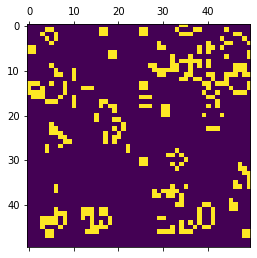

In [ ]:
pool = mp.Pool(mp.cpu_count())
m = mp.Manager()
q = m.Queue()
N = int(input())
num = (n*n)//N
current = num
results = []
it = 0
steps = []
while it < numofit:
  pool = mp.Pool(mp.cpu_count())
  current = num
  remaining = n*n

  while current < n*n:
    pool.apply(poolproc, kwds={'starti': math.floor((current - num)/n), 'startj':math.floor((current-num)%n), 'len':num, 'queue': q})
    temp = current
    current +=num
    remaining -= num

  if current >n*n:
    current = n*n-1
    pool.apply(poolproc, kwds={'starti': math.floor((temp)/n), 'startj':math.floor(temp)%n, 'len':remaining, 'queue': q})
    current +=1
  else:
    pool.apply(poolproc, kwds={'starti': math.floor((current - num)/n), 'startj':math.floor((current-num)%n), 'len':remaining, 'queue': q})


  for t in range(0, n*n):
    message = q.get(timeout = 5)
    split = message.split(" ")
    field[int(split[0])][int(split[1])] = int(split[2])

  print(it)
  it += 1
  pool.close()
  steps.append(list(map(list, field)))

anim1 = animate(steps)
HTML(anim1.to_html5_video())